# Merger Parameterisation Testing

Preliminary Code

In [94]:
%matplotlib inline

In [97]:
# Import libraries
import numpy as np
import marvin
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
from marvin import config
config.access

'public'

In [3]:
config.setDR('DR17')
config.release

'DR17'

Code taken from GitHub Issues page to fix API error

In [4]:
from marvin import config
config.switchSasUrl(sasmode='mirror')

## Unnormalised Residual Velocity Method

As a proof of concept, implement unnormalised residual velocity technique for one galaxy

dvsg_sum:  29688.2294755864


[WARNING]: Warning: converting a masked element to nan. (UserWarning)


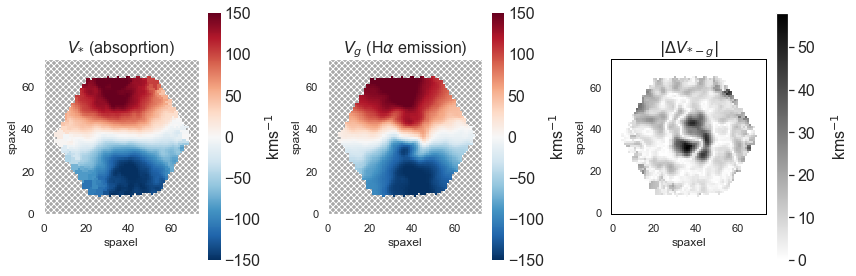

In [270]:
from marvin.tools import Maps

# Load in test map (bottom-left of Smethurst et al., 2018)
maps = Maps("8078-12703")

# Select stellar and gas velocity (H-alpha)
sv = maps.stellar_vel
gv = maps.emline_gvel_ha_6564

# Transform map into set of values
dvsg = np.abs(sv.value - gv.value)

# Calculate summed absolute dvsg value
dvsg_sum = np.sum(dvsg)
print("dvsg_sum: ", dvsg_sum)

# Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
x = np.arange(num_xy)
y = np.arange(num_xy)

# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot stellar velocity
sv.plot(fig=fig, ax=ax[0], cblabel="kms$^{-1}$", cbrange=(-150, 150))

ax[0].set_title(r"$V_{*}$ (absoprtion)", fontsize=16)
ax[0].set_xlabel("spaxel", fontsize=12)
ax[0].set_ylabel("spaxel", fontsize=12)
ax[0].tick_params(axis="x", labelsize=12)
ax[0].tick_params(axis="y", labelsize=12)
ax[0].set_aspect('equal')
ax[0].set_xticks(ticks=np.arange(0, 80, 20))

# Plot gas velocity
gv.plot(fig=fig, ax=ax[1], cblabel="kms$^{-1}$",  cbrange=(-150, 150))

ax[1].set_title(r"$V_{g}$ (H$\alpha$ emission)", fontsize=16)
ax[1].set_xlabel("spaxel", fontsize=12)
ax[1].set_ylabel("spaxel", fontsize=12)
ax[1].set_aspect('equal')

# Plot absolute dvsg colormap and colorabr
dvsg_pcolormesh = ax[2].pcolormesh(x, y, dvsg, cmap=cm.binary, shading="auto")
cbar = fig.colorbar(dvsg_pcolormesh, ax=ax[2])
cbar.ax.tick_params(labelsize=16)
cbar.set_label("kms$^{-1}$", fontsize=16, labelpad=15)

ax[2].set_title(r"$|\Delta V_{*-g}|$", fontsize=16)
ax[2].set_aspect("equal")
ax[2].set_xlabel("spaxel", fontsize=12)
ax[2].set_ylabel("spaxel", fontsize=12)

# Add a border to the plot
for spine in ax[2].spines.values():
    spine.set_edgecolor('black')  # Set the border color
    spine.set_linewidth(1)  # Set the border width


plt.subplots_adjust(left=0.08, wspace=0.2)
plt.tight_layout()

plt.savefig("DVSG_Demonstration.jpg", dpi=400)

Now implement for all galaxies in sample, looping over each kinematic classification individually

In [247]:
# MaNGA codes for each class of rotator
non_reg_ids = ['8600-12703', '8466-6103', '8726-1901']
slow_rot_ids = ['8721-12701', '8481-6101', '8725-1902']
fast_rot_ids = ['8078-12703', '8615-6104', '8597-1902', '8485-1901']

# Combined set of ids (in case studying as one dataset is more helpful/efficient)
combined_ids = non_reg_ids + slow_rot_ids + fast_rot_ids

i =  0
MaNGA ID:  8600-12703
i =  1
MaNGA ID:  8466-6103
i =  2
MaNGA ID:  8726-1901
i =  3
MaNGA ID:  8721-12701
i =  4
MaNGA ID:  8481-6101
i =  5
MaNGA ID:  8725-1902
i =  6
MaNGA ID:  8078-12703
i =  7
MaNGA ID:  8615-6104
i =  8
MaNGA ID:  8597-1902


[WARNING]: Warning: converting a masked element to nan. (UserWarning)


i =  9
MaNGA ID:  8485-1901


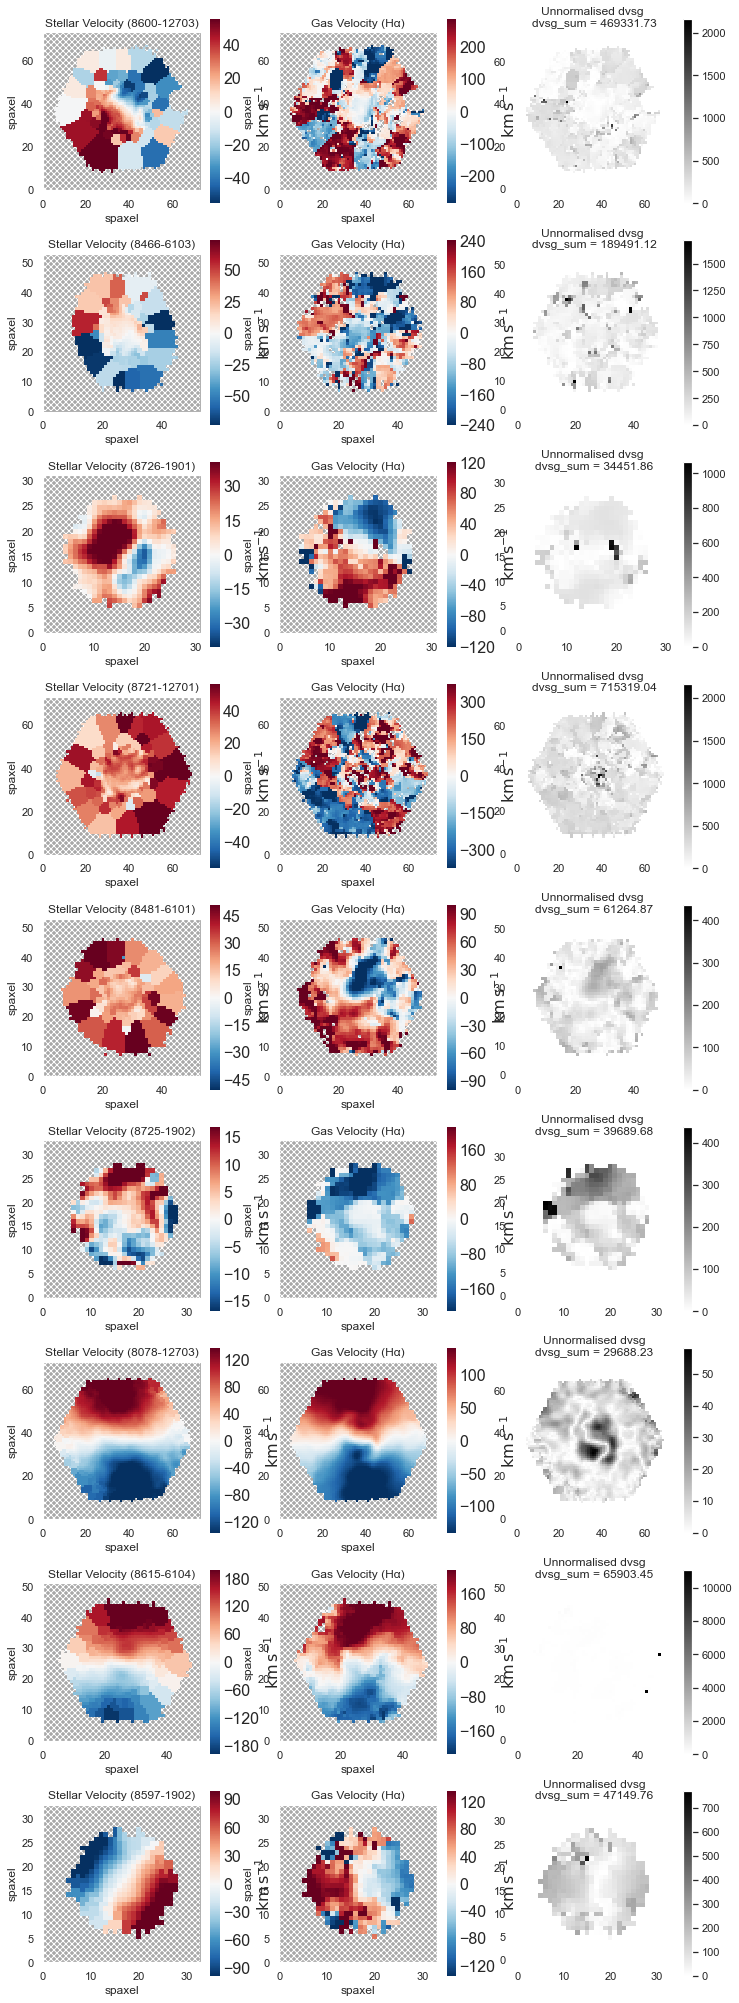

In [265]:
from marvin.tools import Maps

# Initialise arrays to store unnormalised dvsg value for analysis
nr_dvsg_array = np.zeros(len(non_reg_ids))  #  non-regular rotators
sr_dvsg_array = np.zeros(len(slow_rot_ids))  # slow rotators
fr_dvsg_array = np.zeros(len(fast_rot_ids))  # fast rotators

# Initialise arrays to store masked dvsg value for analysis
nr_dvsg_ma_array = np.zeros(len(non_reg_ids))
sr_dvsg_ma_array = np.zeros(len(slow_rot_ids))
fr_dvsg_ma_array = np.zeros(len(fast_rot_ids))

# Initialise arrays to store maximum (absolute) gas velocity value for analysis
nr_gv_max_array = np.zeros(len(non_reg_ids))
sr_gv_max_array = np.zeros(len(slow_rot_ids))
fr_gv_max_array = np.zeros(len(fast_rot_ids))

# Initialise arrays to store maximum (absolute) stellar velocity value for analysis
nr_sv_max_array = np.zeros(len(non_reg_ids))
sr_sv_max_array = np.zeros(len(slow_rot_ids))
fr_sv_max_array = np.zeros(len(fast_rot_ids))

# Initialise arrays to store mean (absolute) gas velocity value for analysis
nr_gv_mean_array = np.zeros(len(non_reg_ids))
sr_gv_mean_array = np.zeros(len(slow_rot_ids))
fr_gv_mean_array = np.zeros(len(fast_rot_ids))

# Initialise arrays to store mean (absolute) stellar velocity value for analysis
nr_sv_mean_array = np.zeros(len(non_reg_ids))
sr_sv_mean_array = np.zeros(len(slow_rot_ids))
fr_sv_mean_array = np.zeros(len(fast_rot_ids))

# Plot initial figure and axes
fig, ax = plt.subplots(nrows=9, ncols=3, figsize=(12, 36))

# Non-regular rotators
for i in range(len(non_reg_ids)):
    # Access map of ith galaxy
    maps = Maps(non_reg_ids[i])

    # Select stellar and gas velocity (H-alpha)
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564
    
    # Mask data
    sv_ma = sv.masked
    gv_ma = gv.masked
    
    print("i = ", i)
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", non_reg_ids[i])
    
    # Calculate resiudal velocity values at each point
    dvsg = np.abs(sv.value - gv.value)
    
    # Calculate summed dvsg value and add to dvsg array
    dvsg_sum = np.sum(dvsg)
    nr_dvsg_array[i] = dvsg_sum
    # print("dvsg_sum: ", dvsg_sum)
    
    # Calculate masked dvsg values at each point
    dvsg_ma = np.abs(sv_ma - gv_ma)
    
    # Calculate summed dvsg value and add to dvsg_ma array
    dvsg_sum_ma = np.sum(dvsg_ma)
    nr_dvsg_ma_array[i] = dvsg_sum_ma
    
    # Add 99% percentile of gv to array
    nr_gv_max_array[i] = np.percentile(np.abs(gv.value), 99)
    
    # Add 99% percentile of sv to array
    nr_sv_max_array[i] = np.percentile(np.abs(sv.value), 99)
    
    # Add mean gv to array
    nr_gv_mean_array[i] = np.mean(np.abs(gv.value))
    
    # Add mean sv to array
    nr_sv_mean_array[i] = np.mean(np.abs(sv.value))
    
    # ONLY PLOTS FIRST 3 OF EACH KIND
    
    if i < 3:
    
        # Use marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
        num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
        x = np.arange(num_xy)
        y = np.arange(num_xy)

        # Plot stellar and gas velocities
        sv.plot(fig=fig, ax=ax[i, 0], title="Stellar Velocity (" + str(non_reg_ids[i]) + ")")
        gv.plot(fig=fig, ax=ax[i, 1], title="Gas Velocity (Hα)")

        # Plot absolute residual colormap
        dvsg_pcolormesh = ax[i, 2].pcolormesh(x, y, dvsg, cmap=cm.binary, shading="auto")
        fig.colorbar(dvsg_pcolormesh, ax=ax[i, 2])
        ax[i, 2].set_title("Unnormalised dvsg \ndvsg_sum = " + "{:.2f}".format(dvsg_sum))
        ax[i, 2].set_aspect("equal")
    
# Slow rotators
for i in range(len(slow_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(slow_rot_ids[i])

    # Select stellar and gas velocity (H-alpha)
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564
    
    # Mask data
    sv_ma = sv.masked
    gv_ma = gv.masked
    
    print("i = ", i + len(non_reg_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", slow_rot_ids[i])
    
    # Calculate resiudal velocity values at each point
    dvsg = np.abs(sv.value - gv.value)
    
    # Calculate summed dvsg value and add to dvsg array
    dvsg_sum = np.sum(dvsg)
    sr_dvsg_array[i] = dvsg_sum
    # print("dvsg_sum: ", dvsg_sum)
    
    # Calculate masked dvsg values at each point
    dvsg_ma = np.abs(sv_ma - gv_ma)
    
    # Calculate summed dvsg value and add to dvsg_ma array
    dvsg_sum_ma = np.sum(dvsg_ma)
    sr_dvsg_ma_array[i] = dvsg_sum_ma
    
    # Add 99% percentile of gv to array
    sr_gv_max_array[i] = np.percentile(np.abs(gv.value), 99)
    
    # Add 99% percentile of sv to array
    sr_sv_max_array[i] = np.percentile(np.abs(sv.value), 99)
    
    # Add mean gv to array
    sr_gv_mean_array[i] = np.mean(np.abs(gv.value))
    
    # Add mean sv to array
    sr_sv_mean_array[i] = np.mean(np.abs(sv.value))
    
    # ONLY PLOT FIRST 3 OF EACH KIND
    
    if i < 3:
    
        # Use marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
        num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
        x = np.arange(num_xy)
        y = np.arange(num_xy)

        # Plot stellar and gas velocities
        sv.plot(fig=fig, ax=ax[i+len(non_reg_ids[:3]), 0], title="Stellar Velocity (" + str(slow_rot_ids[i]) + ")")
        gv.plot(fig=fig, ax=ax[i+len(non_reg_ids[:3]), 1], title="Gas Velocity (Hα)")

        # Plot absolute residual colormap
        dvsg_pcolormesh = ax[i+len(non_reg_ids[:3]), 2].pcolormesh(x, y, dvsg, cmap=cm.binary, shading="auto")
        fig.colorbar(dvsg_pcolormesh, ax=ax[i+len(non_reg_ids[:3]), 2])
        ax[i+len(non_reg_ids[:3]), 2].set_title("Unnormalised dvsg \ndvsg_sum = " + "{:.2f}".format(dvsg_sum))
        ax[i+len(non_reg_ids[:3]), 2].set_aspect("equal")
    
# Fast rotators
for i in range(len(fast_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(fast_rot_ids[i])
    
    # Select stellar and gas velocity (H-alpha)
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564
    
    # Mask data
    sv_ma = sv.masked
    gv_ma = gv.masked
    
    print("i = ", i + len(non_reg_ids) + len(slow_rot_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", fast_rot_ids[i])
    
    # Calculate resiudal velocity values at each point
    dvsg = np.abs(sv.value - gv.value)
    
    # Calculate summed dvsg value and add to dvsg array
    dvsg_sum = np.sum(dvsg)
    fr_dvsg_array[i] = dvsg_sum
    # print("dvsg_sum: ", dvsg_sum)
    
    # Calculate masked dvsg values at each point
    dvsg_ma = np.abs(sv_ma - gv_ma)
    
    # Calculate summed dvsg value and add to dvsg_ma array
    dvsg_sum_ma = np.sum(dvsg_ma)
    fr_dvsg_ma_array[i] = dvsg_sum_ma
    
    # Add 99% percentile of gv to array
    fr_gv_max_array[i] = np.percentile(np.abs(gv.value), 99)
    
    # Add 99% percentile of sv to array
    fr_sv_max_array[i] = np.percentile(np.abs(sv.value), 99)
    
    # Add mean gv to array
    fr_gv_mean_array[i] = np.mean(np.abs(gv.value))
    
    # Add mean sv to array
    fr_sv_mean_array[i] = np.mean(np.abs(sv.value))
    
    # ONLY PLOT FIRST 3 OF EACH KIND
    
    if i < 3:
    
        # Use marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
        num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
        x = np.arange(num_xy)
        y = np.arange(num_xy)

        # Plot stellar and gas velocities
        sv.plot(fig=fig, ax=ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 0], title="Stellar Velocity (" + str(fast_rot_ids[i]) + ")")
        gv.plot(fig=fig, ax=ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 1], title="Gas Velocity (Hα)")

        # Plot absolute dvsg colormap
        dvsg_pcolormesh = ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2].pcolormesh(x, y, dvsg, cmap=cm.binary, shading="auto")
        fig.colorbar(dvsg_pcolormesh, ax=ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2])
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2].set_title("Unnormalised dvsg\ndvsg_sum = " + "{:.2f}".format(dvsg_sum))
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2].set_aspect("equal")

## Normalised Residual Velocity Method

As a proof of concept, implement normalised residual velocity technique for one galaxy

Min of res_vals:  0.0
Max of res_vals:  0.35497622705802023
sum_res_val:  160.37746982916917


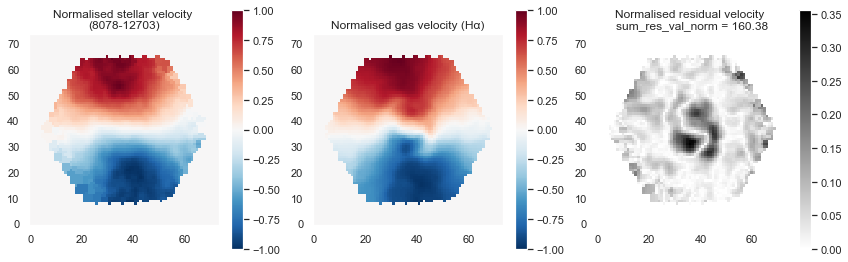

In [236]:
# Use same test example as with unnormalised residual velocity method
maps = Maps('8078-12703')

# Select stellar and gas velocity
sv = maps.stellar_vel
gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha

# Normalise stellar velocity
sv_pos = np.maximum(0, sv.value)
sv_neg = np.minimum(0, sv.value)

sv_pos_norm = sv_pos / np.max(sv_pos)
sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

sv_norm = sv_pos_norm + sv_neg_norm

# Normalise gas velocity
gv_pos = np.maximum(0, gv.value)
gv_neg = np.minimum(0, gv.value)

gv_pos_norm = gv_pos / np.max(gv_pos)
gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

gv_norm = gv_pos_norm + gv_neg_norm

# Calculate residual velocity values
res_vals_norm = np.abs(sv_norm - gv_norm)
print("Min of res_vals: ", np.min(res_vals_norm))
print("Max of res_vals: ", np.max(res_vals_norm))

# Calculate summed absolute residual velocity value
sum_res_val_norm = np.sum(res_vals_norm)
print("sum_res_val: ", sum_res_val_norm)

# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()

# Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
x = np.arange(num_xy)
y = np.arange(num_xy)

# Plot normalised stellar velocity
sv_pcolormesh = ax[0].pcolormesh(x, y, sv_norm, cmap="RdBu_r", shading="auto")
fig.colorbar(sv_pcolormesh, ax=ax[0])
ax[0].set_title("Normalised stellar velocity \n(8078-12703)")
ax[0].set_aspect('equal')

# Plot normalised gas velocity
gv_pcolormesh = ax[1].pcolormesh(x, y, gv_norm, cmap="RdBu_r", shading="auto")
fig.colorbar(gv_pcolormesh, ax=ax[1])
ax[1].set_title("Normalised gas velocity (Hα)")
ax[1].set_aspect('equal')

# Plot absolute residual velocity colormap
rv_pcolormesh = ax[2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
fig.colorbar(rv_pcolormesh, ax=ax[2])
ax[2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
ax[2].set_aspect("equal")

Now implement for all galaxies in sample, looping over each kinematic classification individually

i =  0
MaNGA ID:  8600-12703
Min of res_vals:  0.0
Max of res_vals:  1.4290146955964214
sum_res_val:  998.688878693155
i =  1
MaNGA ID:  8466-6103
Min of res_vals:  0.0
Max of res_vals:  1.3435667478526832
sum_res_val:  513.7092709047558
i =  2
MaNGA ID:  8726-1901
Min of res_vals:  0.0
Max of res_vals:  1.7633913274427635
sum_res_val:  165.04081088198149
i =  3
MaNGA ID:  8721-12701
Min of res_vals:  0.0
Max of res_vals:  1.6203281839419252
sum_res_val:  1514.5969679397429
i =  4
MaNGA ID:  8481-6101
Min of res_vals:  0.0
Max of res_vals:  1.657696835527021
sum_res_val:  430.1827638888621
i =  5
MaNGA ID:  8725-1902
Min of res_vals:  0.0
Max of res_vals:  1.6398926928004498
sum_res_val:  157.2352463646975
i =  6
MaNGA ID:  8078-12703
Min of res_vals:  0.0
Max of res_vals:  0.35497622705802023
sum_res_val:  160.37746982916917
i =  7
MaNGA ID:  8615-6104
Min of res_vals:  0.0
Max of res_vals:  1.2107270396962058
sum_res_val:  329.82837859414184
i =  8
MaNGA ID:  8597-1902
Min of res_val

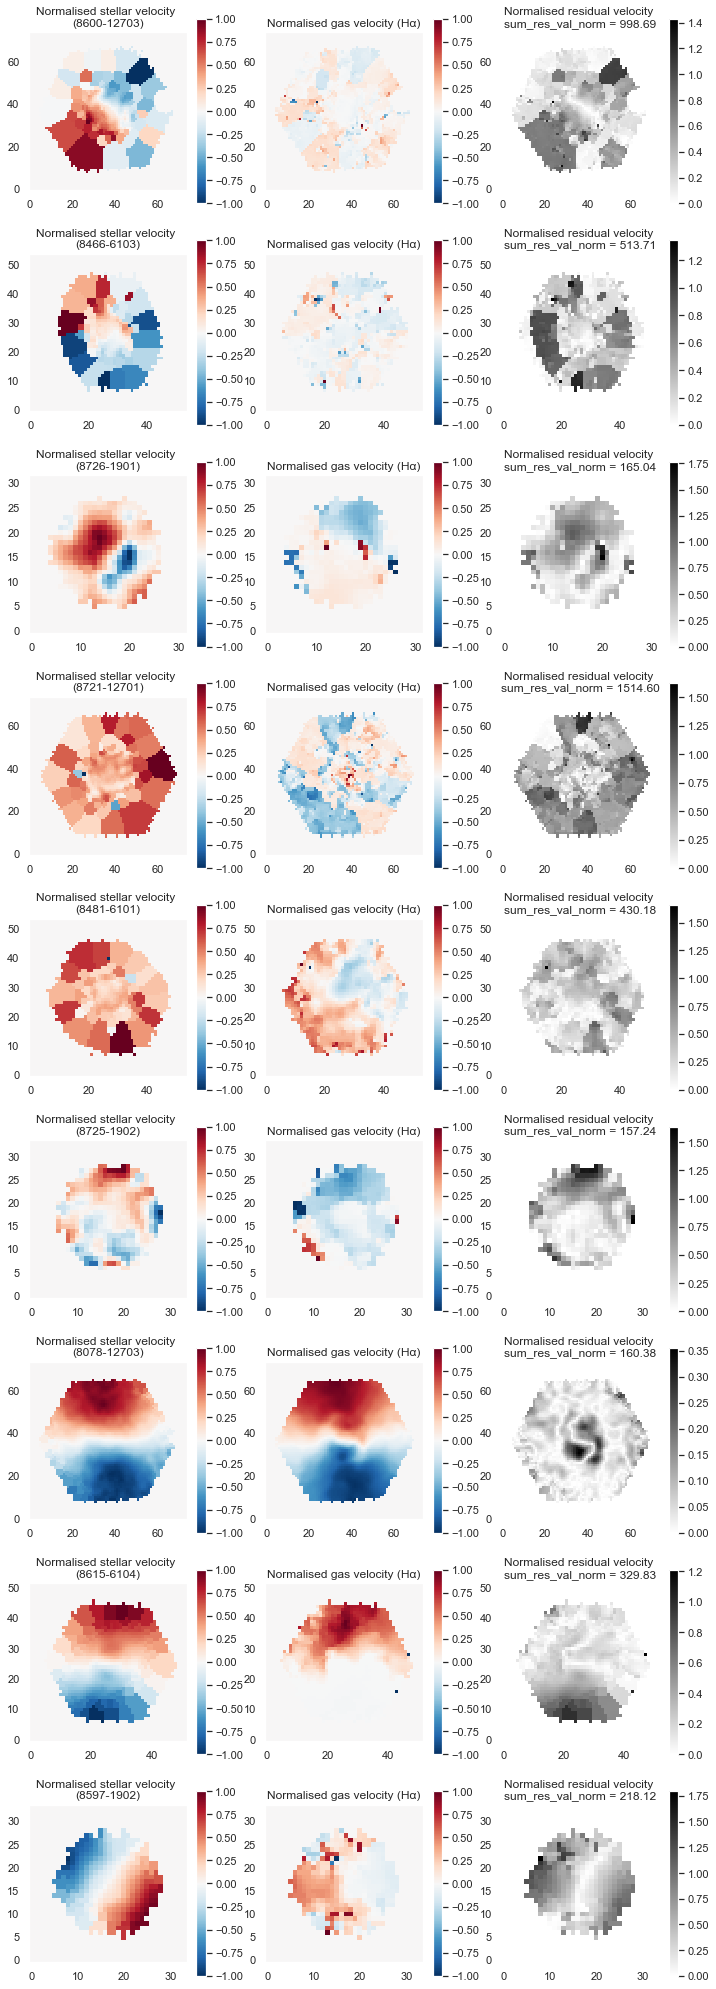

In [244]:
from marvin.tools import Maps

# MaNGA codes for each class of rotator
non_reg_ids = ['8600-12703', '8466-6103', '8726-1901']
slow_rot_ids = ['8721-12701', '8481-6101', '8725-1902']
fast_rot_ids = ['8078-12703', '8615-6104', '8597-1902', '8485-1901']

# Combined set of ids (in case studying as one dataset is more helpful/efficient)
combined_ids = non_reg_ids + slow_rot_ids + fast_rot_ids

# Initialise arrays to store data for analysis
nr_rv_norm_array = np.zeros(len(non_reg_ids))  # store normalised rv value for non-regular rotators
sr_rv_norm_array = np.zeros(len(slow_rot_ids))  # store normalised rv value for slow rotators
fr_rv_norm_array = np.zeros(len(fast_rot_ids))  # store normalised rv value for fast rotators

# Plot initial figure and axes
fig, ax = plt.subplots(nrows=9, ncols=3, figsize=(12, 36))

# Non-regular rotators
for i in range(len(non_reg_ids)):
    # Access map of ith galaxy
    maps = Maps(non_reg_ids[i])
    
    print("i = ", i)
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", non_reg_ids[i])

    # Select stellar and gas velocity
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha
    
    # Normalise stellar velocity
    sv_pos = np.maximum(0, sv.value)
    sv_neg = np.minimum(0, sv.value)
    
    sv_pos_norm = sv_pos / np.max(sv_pos)
    sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

    sv_norm = sv_pos_norm + sv_neg_norm

    # Normalise gas velocity
    gv_pos = np.maximum(0, gv.value)
    gv_neg = np.minimum(0, gv.value)

    gv_pos_norm = gv_pos / np.max(gv_pos)
    gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

    gv_norm = gv_pos_norm + gv_neg_norm
    
    # Calculate residual velocity values
    res_vals_norm = np.abs(sv_norm - gv_norm)
    print("Min of res_vals: ", np.min(res_vals_norm))
    print("Max of res_vals: ", np.max(res_vals_norm))

    # Calculate summed absolute residual velocity value and add to normalised rv array
    sum_res_val_norm = np.sum(res_vals_norm)
    nr_rv_norm_array[i] = sum_res_val_norm
    print("sum_res_val: ", sum_res_val_norm)
    
    # ONLY PLOT FIRST 3 OF EACH KIND
    
    if i < 3:
    
        # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
        num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
        x = np.arange(num_xy)
        y = np.arange(num_xy)

        # Plot normalised stellar velocity
        sv_pcolormesh = ax[i, 0].pcolormesh(x, y, sv_norm, cmap="RdBu_r", shading="auto")
        fig.colorbar(sv_pcolormesh, ax=ax[i, 0])
        ax[i, 0].set_title("Normalised stellar velocity \n(" + str(non_reg_ids[i]) + ")")
        ax[i, 0].set_aspect('equal')

        # Plot normalised gas velocity
        gv_pcolormesh = ax[i, 1].pcolormesh(x, y, gv_norm, cmap="RdBu_r", shading="auto")
        fig.colorbar(gv_pcolormesh, ax=ax[i, 1])
        ax[i, 1].set_title("Normalised gas velocity (Hα)")
        ax[i, 1].set_aspect('equal')

        # Plot absolute residual colormap
        rv_pcolormesh = ax[i, 2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
        fig.colorbar(rv_pcolormesh, ax=ax[i, 2])
        ax[i, 2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
        ax[i, 2].set_aspect("equal")
    
# Slow rotators
for i in range(len(slow_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(slow_rot_ids[i])
    
    print("i = ", i + len(non_reg_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", slow_rot_ids[i])

    # Select stellar and gas velocity
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha
    
    # Normalise stellar velocity
    sv_pos = np.maximum(0, sv.value)
    sv_neg = np.minimum(0, sv.value)
    
    sv_pos_norm = sv_pos / np.max(sv_pos)
    sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

    sv_norm = sv_pos_norm + sv_neg_norm

    # Normalise gas velocity
    gv_pos = np.maximum(0, gv.value)
    gv_neg = np.minimum(0, gv.value)

    gv_pos_norm = gv_pos / np.max(gv_pos)
    gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

    gv_norm = gv_pos_norm + gv_neg_norm
    
    # Calculate residual velocity values
    res_vals_norm = np.abs(sv_norm - gv_norm)
    print("Min of res_vals: ", np.min(res_vals_norm))
    print("Max of res_vals: ", np.max(res_vals_norm))

    # Calculate summed absolute residual velocity value and add to normalised rv array
    sum_res_val_norm = np.sum(res_vals_norm)
    sr_rv_norm_array[i] = sum_res_val_norm
    print("sum_res_val: ", sum_res_val_norm)
    
    # ONLY PLOT FIRST 3 OF EACH KIND
    
    if i < 3:
    
        # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
        num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
        x = np.arange(num_xy)
        y = np.arange(num_xy)

        # Plot normalised stellar velocity
        sv_pcolormesh = ax[i+len(non_reg_ids[:3]), 0].pcolormesh(x, y, sv_norm, cmap="RdBu_r", shading="auto")
        fig.colorbar(sv_pcolormesh, ax=ax[i+len(non_reg_ids[:3]), 0])
        ax[i+len(non_reg_ids[:3]), 0].set_title("Normalised stellar velocity \n(" + str(slow_rot_ids[i]) + ")")
        ax[i+len(non_reg_ids[:3]), 0].set_aspect('equal')

        # Plot normalised gas velocity
        gv_pcolormesh = ax[i+len(non_reg_ids[:3]), 1].pcolormesh(x, y, gv_norm, cmap="RdBu_r", shading="auto")
        fig.colorbar(gv_pcolormesh, ax=ax[i+len(non_reg_ids[:3]), 1])
        ax[i+len(non_reg_ids[:3]), 1].set_title("Normalised gas velocity (Hα)")
        ax[i+len(non_reg_ids[:3]), 1].set_aspect('equal')

        # Plot absolute residual colormap
        rv_pcolormesh = ax[i+len(non_reg_ids[:3]), 2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
        fig.colorbar(rv_pcolormesh, ax=ax[i+len(non_reg_ids[:3]), 2])

        ax[i+len(non_reg_ids[:3]), 2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
        ax[i+len(non_reg_ids[:3]), 2].set_aspect("equal")
    
# Fast rotators
for i in range(len(fast_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(fast_rot_ids[i])
    
    print("i = ", i + len(non_reg_ids) + len(slow_rot_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", fast_rot_ids[i])

    # Select stellar and gas velocity
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha
    
    # Normalise stellar velocity
    sv_pos = np.maximum(0, sv.value)
    sv_neg = np.minimum(0, sv.value)
    
    sv_pos_norm = sv_pos / np.max(sv_pos)
    sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

    sv_norm = sv_pos_norm + sv_neg_norm

    # Normalise gas velocity
    gv_pos = np.maximum(0, gv.value)
    gv_neg = np.minimum(0, gv.value)

    gv_pos_norm = gv_pos / np.max(gv_pos)
    gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

    gv_norm = gv_pos_norm + gv_neg_norm
    
    # Calculate residual velocity values
    res_vals_norm = np.abs(sv_norm - gv_norm)
    print("Min of res_vals: ", np.min(res_vals_norm))
    print("Max of res_vals: ", np.max(res_vals_norm))

    # Calculate summed absolute residual velocity value and add to normalised rv array
    sum_res_val_norm = np.sum(res_vals_norm)
    fr_rv_norm_array[i] = sum_res_val_norm
    print("sum_res_val: ", sum_res_val_norm)
    
    # ONLY PLOT FIRST 3 OF EACH KIND
    
    if i < 3:
    
        # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
        num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
        x = np.arange(num_xy)
        y = np.arange(num_xy)

        # Plot normalised stellar velocity
        sv_pcolormesh = ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 0].pcolormesh(x, y, sv_norm, cmap="RdBu_r", shading="auto")
        fig.colorbar(sv_pcolormesh, ax=ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 0])
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 0].set_title("Normalised stellar velocity \n(" + str(fast_rot_ids[i]) + ")")
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 0].set_aspect('equal')

        # Plot normalised gas velocity
        gv_pcolormesh = ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 1].pcolormesh(x, y, gv_norm, cmap="RdBu_r", shading="auto")
        fig.colorbar(gv_pcolormesh, ax=ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 1])
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 1].set_title("Normalised gas velocity (Hα)")
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 1].set_aspect('equal')

        # Plot absolute residual colormap
        rv_pcolormesh = ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
        fig.colorbar(rv_pcolormesh, ax=ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2])
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
        ax[i+len(non_reg_ids[:3])+len(slow_rot_ids[:3]), 2].set_aspect("equal")

## Analysis of unnormalised RV vs normalised RV

In [19]:
# Print all arrays from unnormalised rv (kinematically distinguished)
print("nr_rv_array: ", nr_rv_array)
print("sr_rv_array: ", sr_rv_array)
print("fr_rv_array: ", fr_rv_array)

# Print all arrays from normalised rv (kinematically distinguished)
print("nr_rv_norm_array: ", nr_rv_norm_array)
print("sr_rv_norm_array: ", sr_rv_norm_array)
print("fr_rv_norm_array: ", fr_rv_norm_array)

nr_rv_array:  [469331.73474568 189491.11500066  34451.8645034 ]
sr_rv_array:  [715319.03803436  61264.87093389  39689.683893  ]
fr_rv_array:  [29688.22947559 65903.44629189 47149.76353416 19263.66031111]
nr_rv_norm_array:  [998.68887869 513.7092709  165.04081088]
sr_rv_norm_array:  [1514.59696794  430.18276389  157.23524636]
fr_rv_norm_array:  [160.37746983 329.82837859 218.12118095  90.78983503]


### Explore relation between unnormalised rv and normalised rv

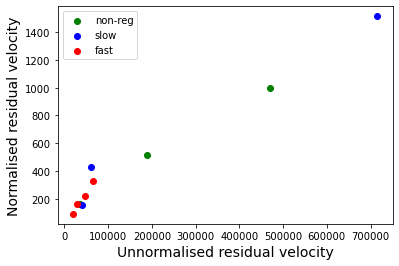

In [20]:
plt.scatter(nr_rv_array, nr_rv_norm_array, color="green", label="non-reg")
plt.scatter(sr_rv_array, sr_rv_norm_array, color="blue", label="slow")
plt.scatter(fr_rv_array, fr_rv_norm_array, color="red", label="fast")

plt.xlabel("Unnormalised residual velocity", fontsize=14)
plt.ylabel("Normalised residual velocity", fontsize=14)
plt.legend()

Relationship is fairly linear for all kinematic classes, suggesting that normalisation may not provide extra information compared with residual velocity

### Explore how (un)normalised rv tracks $\lambda_{Re}$

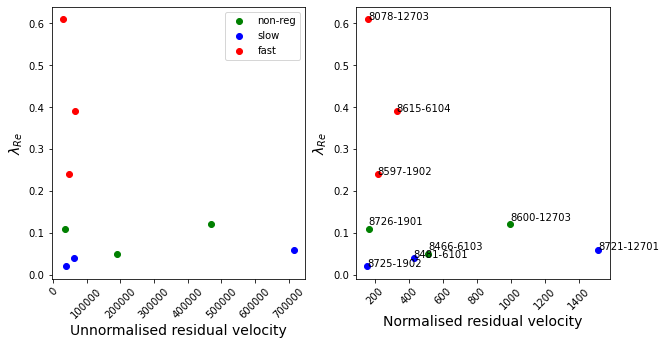

In [39]:
lambda_nr = np.array([0.12, 0.05, 0.11])
lambda_sr = np.array([0.06, 0.04, 0.02])
lambda_fr = np.array([0.61, 0.39, 0.24])  # Leave out extra galaxy until λ_Re known

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# Plot unnormalised rv against λ_Re
ax[0].scatter(nr_rv_array, lambda_nr, color="green", label="non-reg")
ax[0].scatter(sr_rv_array, lambda_sr, color="blue", label="slow")
ax[0].scatter(fr_rv_array[:3], lambda_fr, color="red", label="fast")

ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_xlabel("Unnormalised residual velocity", fontsize=14)
ax[0].set_ylabel("$\lambda_{Re}$", fontsize=14)
ax[0].legend()

# Plot normalised rv against λ_Re
ax[1].scatter(nr_rv_norm_array, lambda_nr, color="green", label="non-reg")
ax[1].scatter(sr_rv_norm_array, lambda_sr, color="blue", label="slow")
ax[1].scatter(fr_rv_norm_array[:3], lambda_fr, color="red", label="fast")

ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_xlabel("Normalised residual velocity", fontsize=14)
ax[1].set_ylabel("$\lambda_{Re}$", fontsize=14)

# Plot Plate IFUs to investigate why some galaxies have higher RV
for i in range(len(non_reg_ids)):
    ax[1].text(nr_rv_norm_array[i], lambda_nr[i] + 0.01, str(non_reg_ids[i]))  # Raised for clarity
for j in range(len(slow_rot_ids)):
    ax[1].text(sr_rv_norm_array[j], lambda_sr[j], str(slow_rot_ids[j]))
for k in range(len(fast_rot_ids[:3])):
    ax[1].text(fr_rv_norm_array[k], lambda_fr[k], str(fast_rot_ids[k]))

Since the unnormalised-normalised rv relationship is linear, it is perhaps unsurprising that the distributions of the two methods' relation to $\lambda_{Re}$ is similar. 

Analysing these relations, given the spread in data along (un)normalised rv for non-regular and slow rotators, it seems that they cannot serve as a base indicators to constrain the kineamatic classification

Fast rotators seem reasonably constrained by both methods, perhaps suggesting that they could evidence that the galaxy has *not* undergone a merger. However, since both slow and non-regular rotators also show low rv values, this may not be accurate and more data would be needed to confirm this

Interestingly, some galaxies (namely slow/non-regular rotators) have very high rv values, which could be a potential sign of distured gas/stars and a merger 

### Compare unnormalised RV against masked RV

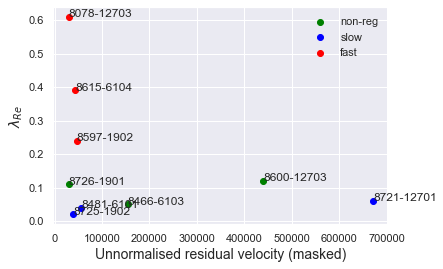

In [252]:
lambda_nr = np.array([0.12, 0.05, 0.11])
lambda_sr = np.array([0.06, 0.04, 0.02])
lambda_fr = np.array([0.61, 0.39, 0.24])  # Leave out extra galaxy until λ_Re known

# Plot unnormalised rv against λ_Re
plt.scatter(nr_rv_ma_array, lambda_nr, color="green", label="non-reg")
plt.scatter(sr_rv_ma_array, lambda_sr, color="blue", label="slow")
plt.scatter(fr_rv_ma_array[:3], lambda_fr, color="red", label="fast")
plt.xlabel("Unnormalised residual velocity (masked)", fontsize=14)
plt.ylabel("$\lambda_{Re}$", fontsize=14)
plt.legend()

# Plot Plate IFUs to investigate why some galaxies have higher RV
for i in range(len(non_reg_ids)):
    plt.annotate(str(non_reg_ids[i]), (nr_rv_ma_array[i], lambda_nr[i]))  # Raised for clarity
for j in range(len(slow_rot_ids)):
    plt.annotate(str(slow_rot_ids[j]), (sr_rv_ma_array[j], lambda_sr[j]))
for k in range(len(fast_rot_ids[:3])):
    plt.annotate(str(fast_rot_ids[k]), (fr_rv_ma_array[k], lambda_fr[k]))

Using masked data seems to clear up the anomalous fast rotator result

### Explore the extent to which different kinematic classes have different (un)normalised rv mean values

In [22]:
# Calculate mean value for each kinematic class
nr_rv_mean = np.mean(nr_rv_array)
sr_rv_mean = np.mean(sr_rv_array)
fr_rv_mean = np.mean(fr_rv_array)

nr_rv_norm_mean = np.mean(nr_rv_norm_array)
sr_rv_norm_mean = np.mean(sr_rv_norm_array)
fr_rv_norm_mean = np.mean(fr_rv_norm_array)

print("nr_rv_mean: ", nr_rv_mean)
print("sr_rv_mean: ", sr_rv_mean)
print("fr_rv_mean: ", fr_rv_mean)

print("\nnr_rv_norm_mean: ", nr_rv_norm_mean)
print("sr_rv_norm_mean: ", sr_rv_norm_mean)
print("fr_rv_norm_mean: ", fr_rv_norm_mean)

# Divide all means by lowest one to see whether normalised and unnormalised means are proportional
print("\nnr_fr_rv_mean_ratio: ", nr_rv_mean / fr_rv_mean)
print("sr_fr_rv_mean_ratio: ", sr_rv_mean / fr_rv_mean)

print("\nnr_fr_rv_norm_mean_ratio: ", nr_rv_norm_mean / fr_rv_norm_mean)
print("sr_fr_rv_norm_mean_ratio: ", sr_rv_norm_mean / fr_rv_norm_mean)

nr_rv_mean:  231091.57141657997
sr_rv_mean:  272091.1976204167
fr_rv_mean:  40501.2749031866

nr_rv_norm_mean:  559.1463201599641
sr_rv_norm_mean:  700.6716593977675
fr_rv_norm_mean:  199.77921610102266

nr_fr_rv_mean_ratio:  5.705785113406342
sr_fr_rv_mean_ratio:  6.718089696455675

nr_fr_rv_norm_mean_ratio:  2.7988212741670773
sr_fr_rv_norm_mean_ratio:  3.507229996555086


The means of slow and mid rotators are substantially higher than fast rotators. This is a similar result to the $\lambda_{Re}$ discussion and, as such, more data would be needed to confirm the power of residual velocity in kinematic classification or determining whether a merger has happened in a galaxy or not

The ratios of the means are roughly half as small for normalised values. However *the ratio of the ratio of means* is roughly similar

### Test whether (un)normalised residual velocity corresponds with stellar mass

[WARNING]: unclosed file <_io.BufferedReader name='/Users/Jonah/sas/dr17/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits'> (ResourceWarning)


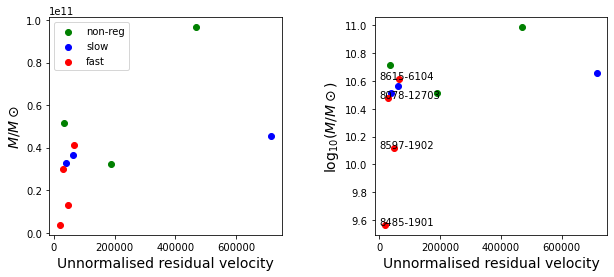

In [41]:
# Use astropy and DRPall to load in stellar masses of all galaxies
from astropy.io import fits

# Open data
drpall = fits.open('/Users/Jonah/sas/dr17/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits')
tbdata = drpall[1].data

nr_mass_array = np.zeros(len(non_reg_ids))
sr_mass_array = np.zeros(len(slow_rot_ids))
fr_mass_array = np.zeros(len(fast_rot_ids))

# Non-regular rotators
for i in range(len(non_reg_ids)):
    # Finding the index for our galaxy using plateifu
    ind = np.where(tbdata['plateifu'] == str(non_reg_ids[i]))[0][0]
    
    # Find elliptical petrosian mass
    elp_mass = tbdata['nsa_elpetro_mass'][ind]
    
    # Add to array
    nr_mass_array[i] = elp_mass
    
# Slow rotators
for i in range(len(slow_rot_ids)):
    # Finding the index for our galaxy using plateifu
    ind = np.where(tbdata['plateifu'] == str(slow_rot_ids[i]))[0][0]
    
    # Find elliptical petrosian mass
    elp_mass = tbdata['nsa_elpetro_mass'][ind]
    
    # Add to array
    sr_mass_array[i] = elp_mass
    
# Fast rotators
for i in range(len(fast_rot_ids)):
    # Finding the index for our galaxy using plateifu
    ind = np.where(tbdata['plateifu'] == str(fast_rot_ids[i]))[0][0]
    
    # Find elliptical petrosian mass
    elp_mass = tbdata['nsa_elpetro_mass'][ind]
    
    # Add to array
    fr_mass_array[i] = elp_mass
    
# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
# Plot resiudal velocity against stellar mass
ax[0].scatter(nr_rv_array, nr_mass_array, color="green", label="non-reg")
ax[0].scatter(sr_rv_array, sr_mass_array, color="blue", label="slow")
ax[0].scatter(fr_rv_array, fr_mass_array, color="red", label="fast")
ax[0].set_xlabel("Unnormalised residual velocity", fontsize=14)
ax[0].set_ylabel("$M/M\odot$", fontsize=14)
ax[0].legend(loc="upper left")    
    
# Plot resiudal velocity against logged stellar mass
ax[1].scatter(nr_rv_array, np.log10(nr_mass_array), color="green", label="non-reg")
ax[1].scatter(sr_rv_array, np.log10(sr_mass_array), color="blue", label="slow")
ax[1].scatter(fr_rv_array, np.log10(fr_mass_array), color="red", label="fast")
ax[1].set_xlabel("Unnormalised residual velocity", fontsize=14)
ax[1].set_ylabel("$\log_{10}(M/M\odot)$", fontsize=14)

# Plot Plate IFUs of fast rotators to investigate why one has higher RV
for i in range(len(fast_rot_ids)):
    ax[1].text(fr_rv_norm_array[i], np.log10(fr_mass_array[i]), str(fast_rot_ids[i]))

Fast rotators tend to have a lower stellar mass, which could suggest lower mass is an indicator of not having merger, but this is not a statistically significant claim with the current data quantity

The galaxy with the largest rv also has the highest mass, which could be causual relationship between the two. This could also be related to the fact that 8615-6104 has the highest mean stellar velocity and nearly the largest 99% value of maximum stellar velocity

### Investigate whether there is any correlation between stellar/gas properties and residual velocity

MaNGA Plate IFU of fast rotator with highest gas velocity:  8615-6104
MaNGA Plate IFU of fast rotator with highest stellar velocity:  8485-1901
MaNGA Plate IFU of fast rotator with highest mean gas velocity:  8615-6104
MaNGA Plate IFU of fast rotator with highest mean stellar velocity:  8615-6104


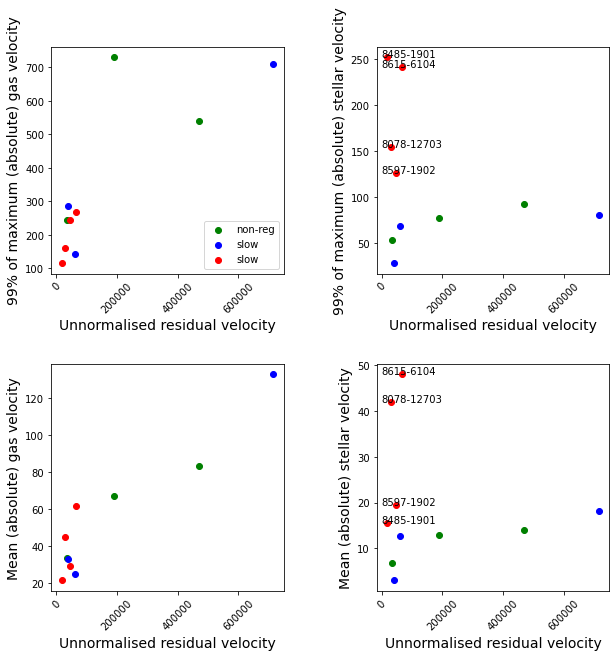

In [49]:
# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Plot maximum gas velocity against unnormalised rv
ax[0, 0].scatter(nr_rv_array, nr_gv_max_array, color="green", label="non-reg")
ax[0, 0].scatter(sr_rv_array, sr_gv_max_array, color="blue", label="slow")
ax[0, 0].scatter(fr_rv_array, fr_gv_max_array, color="red", label="slow")
ax[0, 0].set_xlabel("Unnormalised residual velocity", fontsize=14)
ax[0, 0].set_ylabel("99% of maximum (absolute) gas velocity", fontsize=14)
ax[0, 0].tick_params(axis='x', labelrotation=45)
ax[0, 0].legend()

# Plot maximum stellar velocity aginst unnormalised rv
ax[0, 1].scatter(nr_rv_array, nr_sv_max_array, color="green", label="non-reg")
ax[0, 1].scatter(sr_rv_array, sr_sv_max_array, color="blue", label="slow")
ax[0, 1].scatter(fr_rv_array, fr_sv_max_array, color="red", label="slow")
ax[0, 1].set_xlabel("Unormalised residual velocity", fontsize=14)
ax[0, 1].set_ylabel("99% of maximum (absolute) stellar velocity", fontsize=14)
ax[0, 1].tick_params(axis='x', labelrotation=45)

# Plot mean gas velocity for unnormalised
ax[1, 0].scatter(nr_rv_array, nr_gv_mean_array, color="green", label="non-reg")
ax[1, 0].scatter(sr_rv_array, sr_gv_mean_array, color="blue", label="slow")
ax[1, 0].scatter(fr_rv_array, fr_gv_mean_array, color="red", label="slow")
ax[1, 0].set_xlabel("Unnormalised residual velocity", fontsize=14)
ax[1, 0].set_ylabel("Mean (absolute) gas velocity", fontsize=14)
ax[1, 0].tick_params(axis='x', labelrotation=45)

# Plot mean gas velocity for normalised
ax[1, 1].scatter(nr_rv_array, nr_sv_mean_array, color="green", label="non-reg")
ax[1, 1].scatter(sr_rv_array, sr_sv_mean_array, color="blue", label="slow")
ax[1, 1].scatter(fr_rv_array, fr_sv_mean_array, color="red", label="slow")
ax[1, 1].set_xlabel("Unnormalised residual velocity", fontsize=14)
ax[1, 1].set_ylabel("Mean (absolute) stellar velocity", fontsize=14)
ax[1, 1].tick_params(axis='x', labelrotation=45)

print("MaNGA Plate IFU of fast rotator with highest gas velocity: ", fast_rot_ids[np.where(fr_gv_max_array == np.max(fr_gv_max_array))[0][0]])
print("MaNGA Plate IFU of fast rotator with highest stellar velocity: ", fast_rot_ids[np.where(fr_sv_max_array == np.max(fr_sv_max_array))[0][0]])
print("MaNGA Plate IFU of fast rotator with highest mean gas velocity: ", fast_rot_ids[np.where(fr_gv_mean_array == np.max(fr_gv_mean_array))[0][0]])
print("MaNGA Plate IFU of fast rotator with highest mean stellar velocity: ", fast_rot_ids[np.where(fr_sv_mean_array == np.max(fr_sv_mean_array))[0][0]])

# Plot Plate IFUs to investigate why some galaxies have higher RV
for i in range(len(fast_rot_ids)):
    ax[0, 1].text(fr_rv_norm_array[i], fr_sv_max_array[i], str(fast_rot_ids[i]))
    ax[1, 1].text(fr_rv_norm_array[i], fr_sv_mean_array[i], str(fast_rot_ids[i]))
                  

When the maximum of velocity is used instead of the 99% percentile, the presence of anomalous spaxels and stellar and gas velocity maps not fitting exactly, large differences emerge in some residual velocity calculation. For this reason, the 99% percentile is plotted instead

Fast rotators seem to have the fastest stellar velocity, but have on average the lowest gas gas velocity. Perhaps this is because in a merger we expect the gas velocity to be distrurbed more, so slow/non-regular rotators would have higher velocities. Since fast rotatators are classified by stellar velocity, it is unsurprising that they have higher stellar velocities

Plot stellar velocity against mass to investigate effect of mass on stellar and gas velocity

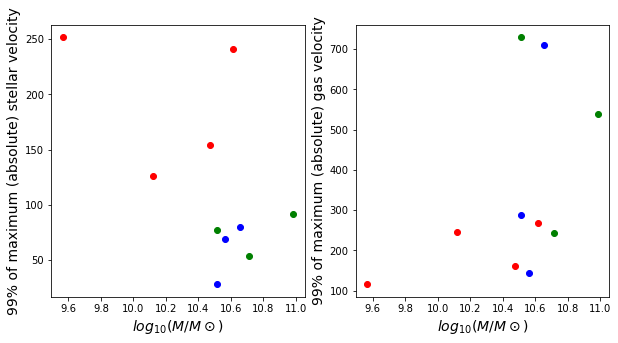

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Stellar velocity
ax[0].scatter(np.log10(nr_mass_array), nr_sv_max_array, color="green", label="non-reg")
ax[0].scatter(np.log10(sr_mass_array), sr_sv_max_array, color="blue", label="slow")
ax[0].scatter(np.log10(fr_mass_array), fr_sv_max_array, color="red", label="fast")
ax[0].set_xlabel("$log_{10}(M/M\odot)$", fontsize=14)
ax[0].set_ylabel("99% of maximum (absolute) stellar velocity", fontsize=14);

# Gas velocity
ax[1].scatter(np.log10(nr_mass_array), nr_gv_max_array, color="green", label="non-reg")
ax[1].scatter(np.log10(sr_mass_array), sr_gv_max_array, color="blue", label="slow")
ax[1].scatter(np.log10(fr_mass_array), fr_gv_max_array, color="red", label="fast")
ax[1].set_xlabel("$log_{10}(M/M\odot)$", fontsize=14)
ax[1].set_ylabel("99% of maximum (absolute) gas velocity", fontsize=14);